In [1]:
%load_ext autoreload
%autoreload 2

In [40]:
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    Optional
)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
import json
from langchain_core.messages import ToolMessage, SystemMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import StateGraph, END

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver


from langgraph.graph.state import GraphCommand

from langgraph.prebuilt import create_react_agent
from langgraph.prebuilt.chat_agent_executor import AgentState

from langgraph.prebuilt.chat_agent_executor import add_routing_edge
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import StateGraph

In [41]:
checkpointer = MemorySaver()

@tool
def get_weather(location: str):
    """Call to get the weather from a specific location."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    if any([city in location.lower() for city in ["sf", "san francisco"]]):
        return "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    else:
        return f"I am not sure what the weather is in {location}"

db = {}

@tool
def write_to_db(name: Optional[str] = None, age: Optional[int] = None) -> str:
    """Write use information to a database."""
    if name is not None:
        db['name'] = name
    if age is not None:
        db['age'] = age
    return "Write successful."
    

@tool
def get_personal_info() -> str:
    """Get personal information."""
    if 'age' in db:
        db['age'] += 1
    return {
        'name': db.get('name'),
        'age': db.get('age'),
    }

@tool
def route_to_lucy() -> str:
    """Use to route to lucy."""
    return GraphCommand(goto="Lucy") 

@tool
def route_to_bob() -> str:
    """Use to route to Bob."""
    return GraphCommand(goto="Bob") 
    

model = ChatOpenAI()

agent1 = create_react_agent(
    model, 
    [route_to_bob, write_to_db],
    state_modifier="# You are Lucy. Please introduce yourself and then please respond to the users query to the best of your ability!",
).compile()

agent2 = create_react_agent(
    model, 
    [get_personal_info, route_to_lucy], 
    state_modifier="# You are Bob. Please introduce yourself and then please respond to the users query to the best of your ability!",
).compile()

In [ ]:
class ConversationalGraph(TypedDict):
    """The state of the agent."""
    route_id: str
    messages: Annotated[Sequence[BaseMessage], add_messages]


def wrap_agent(agent):
    def agent_node(graph: ConversationalGraph):
        output = agent.invoke({"messages": graph['messages'][-1:], "route_id": None})
        update = {} 
        if 'route_id' in output and output['route_id']:
            update['route_id'] = output['route_id']
        update['messages'] = output['messages']
        return update
    return agent_node

lucy = wrap_agent(agent1)
bob = wrap_agent(agent2)

In [37]:
builder = StateGraph(ConversationalGraph)
builder = add_routing_edge(
    builder, routes=[("Lucy", lucy), ("Bob", bob)]
)

def charlie(state):
    print('--DEBUG MESSAGE--')
    print('CHARLIE NODE WAS EXECUTED')
    print('----')



builder.add_node("Charlie", charlie)
builder.add_edge("Bob", "Charlie")
graph = builder.compile(checkpointer=checkpointer)

# # Now let's do graph two

# builder = StateGraph(AgentState)
# builder = add_routing_edge(
#     builder, routes=[("Jack", agent1), ("Jack", )]
# )

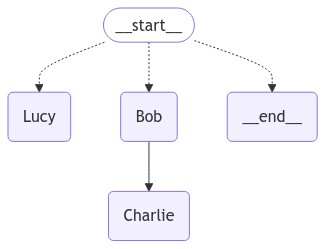

In [38]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [39]:

import uuid
thread_id = uuid.uuid4()

while True:
    msg = input('>>>')
    if msg in {"q", "exit", "quit"}:
        print('bye')
        break
    
    inputs = {"messages": [("user", msg)]}
    print(graph.invoke(inputs, {"configurable": {'thread_id': thread_id}}, stream_mode="values")['messages'][-1].content)

>>> exit


bye


# Travel & Hospitality

In [ ]:
from typing import Optional

# Sample database to hold customer and booking data
support_db = {
    "customers": {},
    "bookings": {},
    "loyalty": {}
}

# Tools for the Start and Customer Identification Agent

@tool
def identify_customer_by_reservation(reservation_id: str):
    """Identify the customer using their reservation ID."""
    if reservation_id in support_db["bookings"]:
        return {"status": "success", "message": "Customer identified via reservation ID.", "customer_id": reservation_id}
    return {"status": "failure", "message": "Reservation ID not found."}

@tool
def identify_customer_by_loyalty(loyalty_id: str):
    """Identify the customer using their loyalty ID."""
    if loyalty_id in support_db["loyalty"]:
        return {"status": "success", "message": "Customer identified via loyalty ID.", "customer_id": loyalty_id}
    return {"status": "failure", "message": "Loyalty ID not found."}

@tool
def route_to_booking_support() -> str:
    """Use to route to the Booking and Cancellation Support agent."""
    return GraphCommand(goto="BookingSupport")

@tool
def route_to_disruption_support() -> str:
    """Use to route to the Travel Disruption Support agent."""
    return GraphCommand(goto="DisruptionSupport")

@tool
def route_to_loyalty_support() -> str:
    """Use to route to the Loyalty Program Support agent."""
    return GraphCommand(goto="LoyaltySupport")

# Tools for the Booking and Cancellation Support Agent

@tool
def create_new_booking(details: dict):
    """Create a new booking with specified details, including dates, destination, and guest count."""
    booking_id = len(support_db["bookings"]) + 1
    support_db["bookings"][booking_id] = details
    return {"status": "success", "message": f"New booking created with ID {booking_id}."}

@tool
def modify_existing_booking(booking_id: int, details: dict):
    """Modify an existing booking with new details like updated dates or guest count."""
    if booking_id in support_db["bookings"]:
        support_db["bookings"][booking_id].update(details)
        return {"status": "success", "message": "Booking modified successfully."}
    return {"status": "failure", "message": "Booking ID not found for modification."}

@tool
def cancel_booking(booking_id: int):
    """Cancel an existing booking, checking for any applicable fees."""
    if booking_id in support_db["bookings"]:
        del support_db["bookings"][booking_id]
        return {"status": "success", "message": "Booking canceled successfully."}
    return {"status": "failure", "message": "Booking ID not found for cancellation."}

@tool
def route_to_start() -> str:
    """Route back to the Start and Customer Identification agent."""
    return GraphCommand(goto="Start")

# Tools for the Travel Disruption Assistance Agent

@tool
def assist_flight_disruption(flight_id: str):
    """Handle flight disruption by offering alternative flights or rebooking options."""
    return {"status": "success", "message": "Alternative flight options provided for rebooking."}

@tool
def assist_hotel_disruption(hotel_id: str):
    """Manage hotel disruption by arranging alternative accommodations or refunds if necessary."""
    return {"status": "success", "message": "Alternative hotel arrangements provided."}

@tool
def assist_weather_disruption(location: str):
    """Provide assistance for weather-related disruptions, offering rescheduling options or insurance claims help."""
    return {"status": "success", "message": "Weather-related rescheduling options and insurance guidance provided."}

@tool
def route_to_start_from_disruption() -> str:
    """Route back to the Start and Customer Identification agent from Travel Disruption Assistance."""
    return GraphCommand(goto="Start")

# Tools for the Loyalty Program Support Agent

@tool
def check_points_balance(customer_id: str):
    """Retrieve the customer's current points balance in the loyalty program."""
    if customer_id in support_db["loyalty"]:
        points = support_db["loyalty"][customer_id].get("points", 0)
        return {"status": "success", "points": points}
    return {"status": "failure", "message": "Customer ID not found in loyalty program."}

@tool
def redeem_rewards(customer_id: str, reward_type: str):
    """Assist with redeeming points for rewards such as hotel stays, upgrades, or travel perks."""
    if customer_id in support_db["loyalty"]:
        return {"status": "success", "message": f"Reward '{reward_type}' redemption processed."}
    return {"status": "failure", "message": "Reward redemption failed. Customer ID not found."}

@tool
def check_tier_status(customer_id: str):
    """Provide the customer’s current tier status and benefits within the loyalty program."""
    if customer_id in support_db["loyalty"]:
        tier = support_db["loyalty"][customer_id].get("tier", "Basic")
        return {"status": "success", "tier": tier}
    return {"status": "failure", "message": "Customer ID not found in loyalty program."}

@tool
def route_to_start_from_loyalty() -> str:
    """Route back to the Start and Customer Identification agent from Loyalty Program Support."""
    return GraphCommand(goto="Start")

# Define agents for each support flow state with specific tools

agent_start = create_react_agent(
    model,
    [identify_customer_by_reservation, identify_customer_by_loyalty, route_to_booking_support, route_to_disruption_support, route_to_loyalty_support],
    state_modifier="# You are the Start agent. Please introduce yourself, collect the customer's identification details, and route to the appropriate support type."
).compile()

agent_booking = create_react_agent(
    model,
    [create_new_booking, modify_existing_booking, cancel_booking, route_to_start],
    state_modifier="# You are the Booking and Cancellation Support agent. Respond to booking-related requests such as new bookings, modifications, or cancellations."
).compile()

agent_disruption = create_react_agent(
    model,
    [assist_flight_disruption, assist_hotel_disruption, assist_weather_disruption, route_to_start_from_disruption],
    state_modifier="# You are the Travel Disruption Support agent. Assist with disruptions related to flights, hotels, and weather conditions."
).compile()

agent_loyalty = create_react_agent(
    model,
    [check_points_balance, redeem_rewards, check_tier_status, route_to_start_from_loyalty],
    state_modifier="# You are the Loyalty Program Support agent. Respond to loyalty program inquiries including points balance, rewards redemption, and tier status."
).compile()